In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from data_preprocessing_class import TextProcessor
from gensim import corpora
from gensim.models import LdaModel
import warnings

In [2]:
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

In [3]:
reddit_api_info_nw_insights = pd.read_csv("subreddit_data_info_nw_insights.csv")
reddit_api_subreddit_add_info = pd.read_csv("subreddit_data_add_info.csv")
reddit_network_data = pd.read_csv("subreddit_network_data.csv")

In [4]:
merged_data = pd.merge(reddit_api_info_nw_insights, reddit_api_subreddit_add_info, on="Subreddit")
merged_data = pd.merge(merged_data, reddit_network_data, on="Subreddit")
merged_data = merged_data.loc[:, ~merged_data.columns.str.contains('^Unnamed')]


In [5]:
# Posts
posts_df = merged_data[['Subreddit', 'Top 10 Posts']].copy()
posts_df['Top 10 Posts'] = posts_df['Top 10 Posts'].apply(ast.literal_eval)
expanded_posts_df = posts_df.explode('Top 10 Posts').reset_index(drop=True)

# Comments
comments_df = merged_data[['Subreddit', 'Top 10 Comments']].copy()
comments_df['Top 10 Comments'] = comments_df['Top 10 Comments'].apply(ast.literal_eval)
expanded_comments_df = comments_df.explode('Top 10 Comments').reset_index(drop=True)

In [6]:
processor = TextProcessor()
subreddit_posts_df = processor.text_preprocessed(expanded_posts_df, 'Top 10 Posts')
subreddit_comments_df = processor.text_preprocessed(expanded_comments_df, 'Top 10 Comments')

aggregated_posts_df = subreddit_posts_df.groupby('Subreddit')['tokens'].agg(sum).reset_index()

aggregated_comments_df = subreddit_comments_df.groupby('Subreddit')['tokens'].agg(sum).reset_index()

In [7]:
def prepare_dictionary_and_corpus(texts, no_below=5, no_above=0.3):
    dictionary = corpora.Dictionary(texts)
    dictionary.filter_extremes(no_below=no_below, no_above=no_above)
    dictionary.compactify()
    corpus = [dictionary.doc2bow(text) for text in texts]
    return dictionary, corpus

In [8]:
def topic_modeling(corpus, dictionary, num_topics=3):
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=20, random_state=5664)
    return lda_model

In [9]:
# Function to assign topics to documents
def assign_topics(ldamodel, corpus):
    topics = [sorted(ldamodel.get_document_topics(doc), key=lambda x: x[1], reverse=True)[0][0] for doc in corpus]
    return topics

In [10]:
# Function to print topics
def print_topics(ldamodel, num_topics=3):
    for idx, topic in ldamodel.print_topics(num_topics):
        print('Topic: {} \nWords: {}'.format(idx, topic))

In [11]:
dictionary_posts, corpus_posts = prepare_dictionary_and_corpus(aggregated_posts_df['tokens'])
lda_model_posts = topic_modeling(corpus_posts, dictionary_posts)
aggregated_posts_df['topic'] = assign_topics(lda_model_posts, corpus_posts)

dictionary_comments, corpus_comments = prepare_dictionary_and_corpus(aggregated_comments_df['tokens'])
lda_model_comments = topic_modeling(corpus_comments, dictionary_comments)
aggregated_comments_df['topic'] = assign_topics(lda_model_comments, corpus_comments)

In [12]:
print("Topics for subreddit posts:")
print_topics(lda_model_posts)

print("Topics assigned to the posts:")
print(aggregated_posts_df[['Subreddit', 'topic']].head())

topic_crosstab_posts = pd.crosstab(aggregated_posts_df['Subreddit'], aggregated_posts_df['topic'])
print("Topic distribution in posts:")
print(topic_crosstab_posts)

print("Topics for subreddit comments:")
print_topics(lda_model_comments)

print("Topics assigned to the comments:")
print(aggregated_comments_df[['Subreddit', 'topic']].head())

topic_crosstab_comments = pd.crosstab(aggregated_comments_df['Subreddit'], aggregated_comments_df['topic'])
print("Topic distribution in comments:")
print(topic_crosstab_comments)

Topics for subreddit posts:
Topic: 0 
Words: 0.021*"his" + 0.017*"has" + 0.016*"her" + 0.016*"would" + 0.015*"but" + 0.015*"do" + 0.014*"they" + 0.014*"if" + 0.014*"was" + 0.013*"animals"
Topic: 1 
Words: 0.036*"dog" + 0.022*"by" + 0.021*"cat" + 0.016*"found" + 0.015*"are" + 0.014*"got" + 0.013*"her" + 0.012*"out" + 0.012*"so" + 0.011*"good"
Topic: 2 
Words: 0.019*"big" + 0.019*"so" + 0.017*"if" + 0.015*"first" + 0.014*"your" + 0.014*"its" + 0.014*"guys" + 0.013*"all" + 0.013*"would" + 0.013*"dont"
Topics assigned to the posts:
          Subreddit  topic
0      ACPocketCamp      2
1  Adorable_Animals      1
2     AdviceAnimals      0
3  AnimalCollective      2
4    AnimalCrossing      1
Topic distribution in posts:
topic             0  1  2
Subreddit                
ACPocketCamp      0  0  1
Adorable_Animals  0  1  0
AdviceAnimals     1  0  0
AnimalCollective  0  0  1
AnimalCrossing    0  1  0
...              .. .. ..
todayilearned     1  0  0
unpopularopinion  0  0  1
vegan          

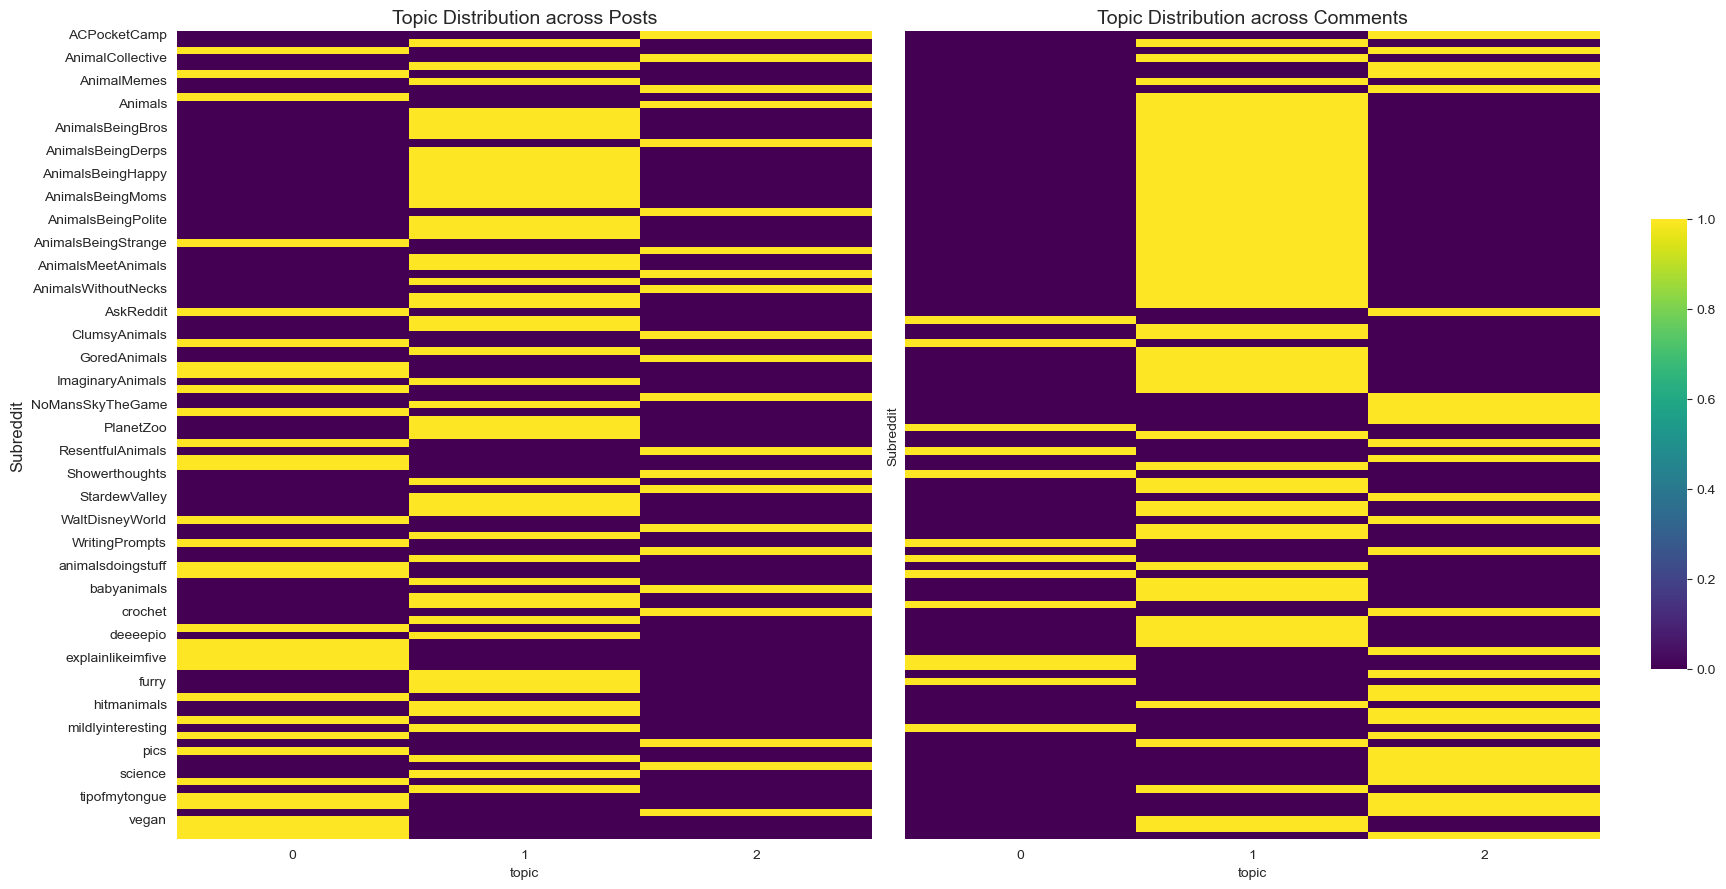

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 9), sharey=True)
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])

sns.heatmap(topic_crosstab_posts, annot=False, fmt="d", ax=axes[0], cmap="viridis", cbar_ax=cbar_ax)
axes[0].set_title('Topic Distribution across Posts', fontsize=14)
axes[0].set_ylabel("Subreddit", fontsize=12)
axes[0].tick_params(axis='y', labelsize=10)

sns.heatmap(topic_crosstab_comments, annot=False, fmt="d", ax=axes[1], cmap="viridis", cbar=False)
axes[1].set_title('Topic Distribution across Comments', fontsize=14)
axes[1].tick_params(axis='y', labelsize=10)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()